## Task 2

Transformer Encoder

In [77]:
import torch
import sts_data
import siamese_lstm_attention_with_transformer
#import sample_class
#import sample_train
import train
import test
from importlib import reload

reload(sts_data)
from sts_data import STSData

columns_mapping = {
        "sent1": "sentence_A",
        "sent2": "sentence_B",
        "label": "relatedness_score",
    }
dataset_name = "sick"
sick_data = STSData(
    dataset_name=dataset_name,
    columns_mapping=columns_mapping,
    normalize_labels=True,
    normalization_const=5.0,
)
batch_size = 64
sick_dataloaders = sick_data.get_data_loader(batch_size=batch_size)

INFO:root:loading and preprocessing data...
INFO:root:reading and preprocessing data completed...
INFO:root:creating vocabulary...
INFO:torchtext.vocab:Loading vectors from .vector_cache\wiki.simple.vec.pt
INFO:root:creating vocabulary completed...


In [78]:
output_size = 1
hidden_size = 256
vocab_size = len(sick_data.vocab)
embedding_size = 300
embedding_weights = sick_data.vocab.vectors
lstm_layers = 3
learning_rate = 1e-2
fc_hidden_size = 1024
max_epochs = 5
bidirectional = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## self attention config
self_attention_config = {
    "hidden_size": 350,  ## refers to variable 'da' in the ICLR paper
    "output_size": 30,  ## refers to variable 'r' in the ICLR paper
    "penalty": 1,  ## refers to penalty coefficient term in the ICLR paper
}

In [99]:
reload(siamese_lstm_attention_with_transformer)
import Trans_Encoder as trans
reload(trans)
from siamese_lstm_attention_with_transformer import SiameseBiLSTMAttention
## init siamese lstm
siamese_lstm_attention_model = SiameseBiLSTMAttention(
    batch_size=batch_size,
    output_size=output_size,
    hidden_size=hidden_size,
    vocab_size=vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    lstm_layers=lstm_layers,
    self_attention_config=self_attention_config,
    fc_hidden_size=fc_hidden_size,
    device=device,
    bidirectional=bidirectional,
)
## move model to device
siamese_lstm_attention_model.to(device)



SiameseBiLSTMAttention(
  (embeddings): Embedding(2052, 300)
  (transformer_encoder): Transformer(
    (encoder): Encoder(
      (pe): PositionalEncoder()
      (layers): ModuleList(
        (0): EncoderLayer(
          (norm_1): Norm()
          (norm_2): Norm()
          (attn): MultiHeadAttention(
            (q_linear): Linear(in_features=300, out_features=300, bias=True)
            (v_linear): Linear(in_features=300, out_features=300, bias=True)
            (k_linear): Linear(in_features=300, out_features=300, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (out): Linear(in_features=300, out_features=300, bias=True)
          )
          (ff): FeedForward(
            (linear_1): Linear(in_features=300, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear_2): Linear(in_features=2048, out_features=300, bias=True)
          )
          (dropout_1): Dropout(p=0.1, inplace=False)
          (dropout_2): Drop

In [87]:
reload(train)

from train import train_model
import torch.optim as optim


optimizer = torch.optim.Adam(siamese_lstm_attention_model.parameters(), lr=learning_rate, betas=(0.9, 0.98))

siamese_lstm_attention = train_model(
    model=siamese_lstm_attention_model,
    optimizer=optimizer,
    dataloader=sick_dataloaders,
    data=sick_data,
    max_epochs=max_epochs,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Running EPOCH 1


  0%|                                                                                            | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [100]:
import test
from test import evaluate_test_set

reload(test)
attn_scores1, attn_scores2  = evaluate_test_set(
    model=siamese_lstm_attention_model,
    data_loader=sick_dataloaders,
    config_dict={
        "device": device,
        "model_name": "siamese_lstm_attention",
        "self_attention_config": self_attention_config,
    },
)

INFO:root:Evaluating accuracy on test set
INFO:root:Evaluating accuracy on test set


Finished testing..............
Total test set accuracy: 1.000


## Multihead attention visualisation

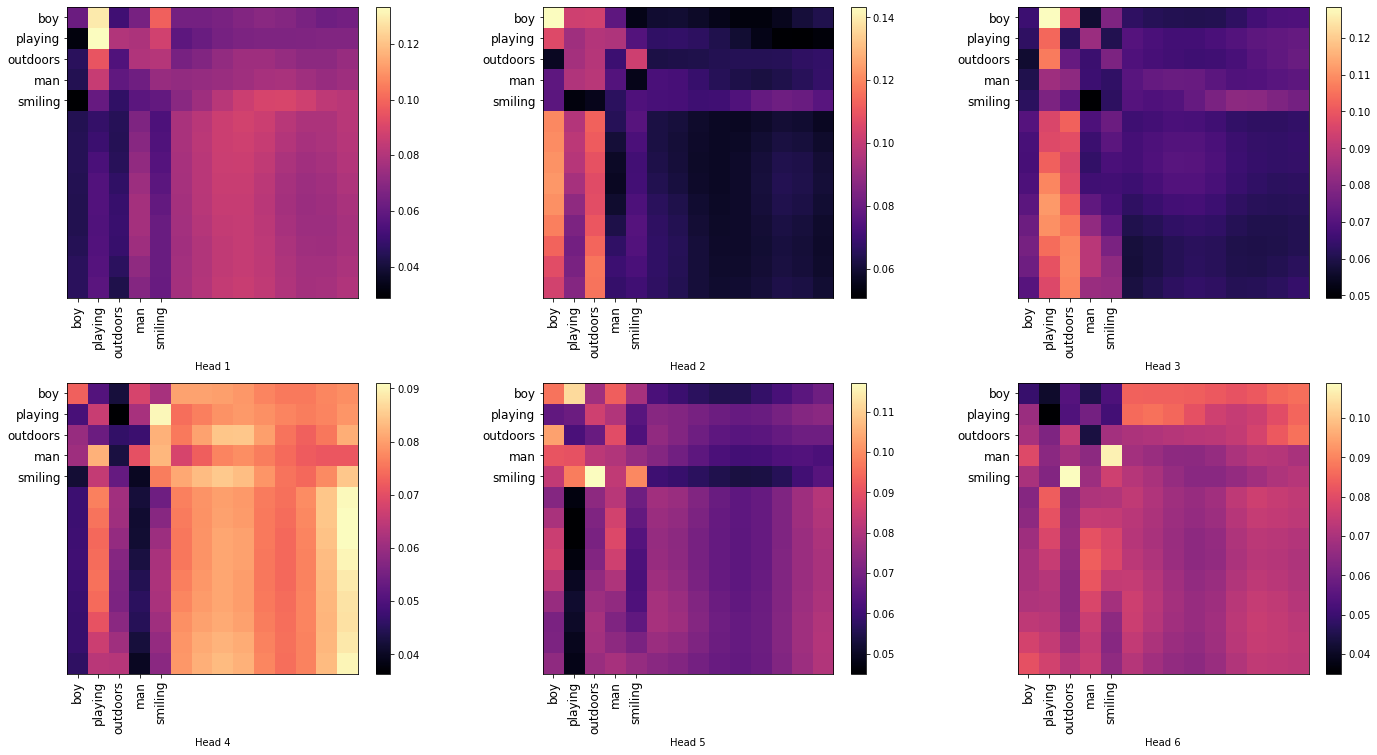

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# first sentence sequence in test dataset (Note: sentences are preprocessed, with stop-word removal)
senA_1 = ['boy', 'playing', 'outdoors', 'man', 'smiling']
senB_1 = ['group', 'kids', 'playing', 'yard', 'old', 'man', 'standing', 'background']


def visualize_scores(scores_mat, sentence, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='magma')

        fontdict = {'fontsize': 12}

        ax.set_xticks(range(len(sentence)))
        ax.set_yticks(range(len(sentence)))

        ax.set_xticklabels(sentence, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(sentence, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    
    
# heatmaps of final encoder layer for sentence A (empty spaces are for padding)
visualize_scores(attn_scores1.squeeze().detach().numpy(), senA_1)



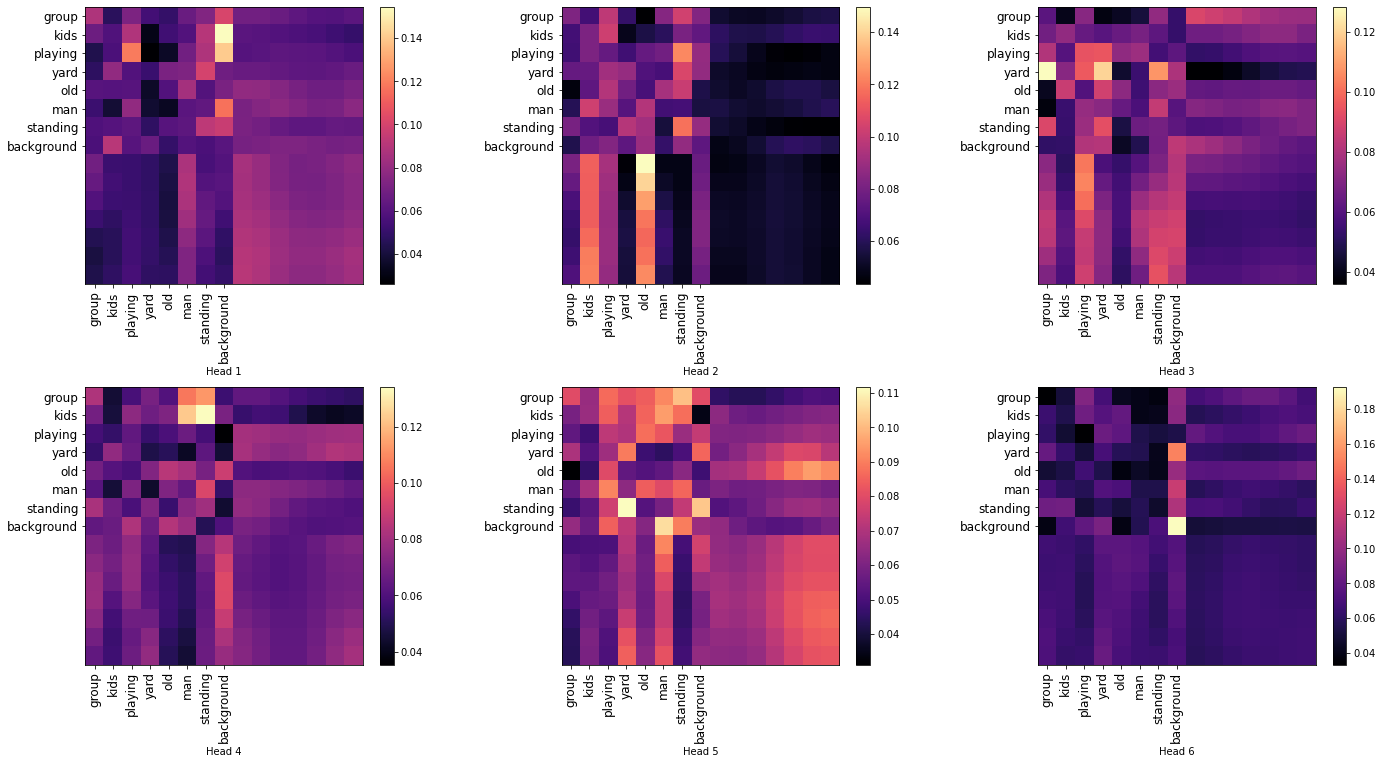

In [103]:
# heatmaps of final encoder layer for sentence B (empty spaces are for padding)
visualize_scores(attn_scores2.squeeze().detach().numpy(), senB_1)

## Code References:

1. Attention heatmap visualisation: https://captum.ai/tutorials/Bert_SQUAD_Interpret2
2. Self-attentive sentence embeddings (for Task 1 model/utility function reference): https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/models/selfAttention.py
